In [130]:
import pandas as pd
import numpy as np

In [131]:
df_AMEX = pd.read_csv('Data/AMEX_01071962_31121999_with_out_shares.csv')
df_NYSE = pd.read_csv('Data/NYSE_01071962_31121999_with_out_shares.csv')

# Are these all common shares? Hard to tell if there are any preference shares involved. Possibly share class might say but this usually means it is common

df_AMEX_NYSE = pd.concat([df_AMEX, df_NYSE], axis=0)

/Users/jamesmcgreevy/.pyenv/versions/3.10.0/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3460: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [132]:
#there are a number of NA's where no price,volume or return data is available
df_AMEX_NYSE=df_AMEX_NYSE.dropna()

In [133]:
# Remove rows from df where return value was C
df_AMEX_NYSE = df_AMEX_NYSE[df_AMEX_NYSE['RET'] != 'C']

df_AMEX_NYSE

,PERMNO,date,EXCHCD,COMNAM,PRC,VOL,RET,SHROUT
0,10028,1992-03-18,2,AMERICAN PACIFIC MINT INC,3.000,17400.0,-0.111111,5548.0
1,10028,1992-03-19,2,AMERICAN PACIFIC MINT INC,3.125,8700.0,0.041667,5548.0
2,10028,1992-03-20,2,AMERICAN PACIFIC MINT INC,3.125,1200.0,0.000000,5548.0
3,10028,1992-03-23,2,AMERICAN PACIFIC MINT INC,2.875,3900.0,-0.080000,5548.0
4,10028,1992-03-24,2,AMERICAN PACIFIC MINT INC,2.875,2000.0,0.000000,5548.0
...,...,...,...,...,...,...,...,...
15956187,93201,1990-02-14,1,WYSE TECHNOLOGY,10.000,11300.0,0.012658,14843.0
15956188,93201,1990-02-15,1,WYSE TECHNOLOGY,9.875,6500.0,-0.012500,14843.0
15956189,93201,1990-02-16,1,WYSE TECHNOLOGY,9.750,5700.0,-0.012658,14843.0
15956190,93201,1990-02-20,1,WYSE TECHNOLOGY,9.875,13100.0,0.012821,14843.0


In [134]:
# Do some tidying up. Create new columns for year and month
df_AMEX_NYSE['year'] = df_AMEX_NYSE['date'].apply(lambda x: x[:4])
df_AMEX_NYSE['month'] = df_AMEX_NYSE['date'].apply(lambda x: x[5:7])

# Change string values to float
df_AMEX_NYSE['PERMNO'] = df_AMEX_NYSE['PERMNO'].astype(int)
df_AMEX_NYSE['year'] = df_AMEX_NYSE['year'].astype(int)
df_AMEX_NYSE['month'] = df_AMEX_NYSE['month'].astype(int)
df_AMEX_NYSE['RET'] = df_AMEX_NYSE['RET'].astype(float)
df_AMEX_NYSE['PRC'] = df_AMEX_NYSE['PRC'].astype(float)
df_AMEX_NYSE['VOL'] = df_AMEX_NYSE['VOL'].astype(float)
df_AMEX_NYSE['SHROUT'] = df_AMEX_NYSE['SHROUT'].astype(float)

# Sort as looks nicer
df_AMEX_NYSE = df_AMEX_NYSE.sort_values(['PERMNO', 'date'])

In [135]:
df_AMEX_NYSE = df_AMEX_NYSE.set_index(['PERMNO', 'year', 'month', 'date'])

In [136]:
# Really important, from CRSP website: 'Sometimes you see negative stock prices in CRSP. This means that there was no closing price available for that period. 
# Instead the bid/ask average was used. To distinguish the bid/ask averages from actual closing prices, CRSP puts a leading dash in front of the price when the bid/ask average was used.'
# Hence we need to multiply any PRC with a dash in front by -1 to get a positive price
df_AMEX_NYSE[df_AMEX_NYSE['PRC'] <= 0]

df_AMEX_NYSE['PRC'] = df_AMEX_NYSE['PRC'].apply(lambda x: -x if x < 0 else x)

In [137]:
# Now that the prices are corrected, add column for dollar vol and market cap in millions
df_AMEX_NYSE['DOLLAR VOL'] = ((df_AMEX_NYSE['VOL'] * df_AMEX_NYSE['PRC']) / 1_000_000)
df_AMEX_NYSE['MKT CAP'] = ((df_AMEX_NYSE['PRC'] * df_AMEX_NYSE['SHROUT']) / 1_000_000)

In [138]:
df_AMEX_NYSE

EXCHCD                       COMNAM       PRC  \
PERMNO year month date                                                        
10006  1962 7     1962-07-02       1         A C F INDUSTRIES INC  62.00000   
                  1962-07-03       1         A C F INDUSTRIES INC  61.12500   
                  1962-07-05       1         A C F INDUSTRIES INC  61.00000   
                  1962-07-06       1         A C F INDUSTRIES INC  60.50000   
                  1962-07-09       1         A C F INDUSTRIES INC  61.00000   
...                              ...                          ...       ...   
93236  1998 9     1998-09-14       2  PACIFIC PHARMACEUTICALS INC   0.18750   
                  1998-09-15       2  PACIFIC PHARMACEUTICALS INC   0.25000   
                  1998-09-16       2  PACIFIC PHARMACEUTICALS INC   0.25000   
                  1998-09-17       2  PACIFIC PHARMACEUTICALS INC   0.18750   
                  1998-09-18       2  PACIFIC PHARMACEUTICALS INC   0.21875   

                                  VOL       RET   SHROUT  DOLLAR VOL   MKT CAP  
PERMNO year month date                                                          
10006  1962 7     1962-07-02   1700.0  0.050847   1453.0    0.105400  0.090086  
                  1962-07-03   2800.0 -0.014113   1453.0    0.171150  0.088815  
                  1962-07-05   2200.0 -0.002045   1453.0    0.134200  0.088633  
                  1962-07-06   2300.0 -0.008197   1453.0    0.139150  0.087906  
                  1962-07-09    900.0  0.008264   1453.0    0.054900  0.088633  
...                               ...       ...      ...         ...       ...  
93236  1998 9     1998-09-14  24900.0 -0.250000  11257.0    0.004669  0.002111  
                  1998-09-15  29000.0  0.333333  11257.0    0.007250  0.002814  
                  1998-09-16  55600.0  0.000000  11257.0    0.013900  0.002814  
                  1998-09-17  29200.0 -0.250000  11257.0    0.005475  0.002111  
                  1998-09-18  28700.0  0.166667  11272.0    0.006278  0.002466  

[24509590 rows x 8 columns]

In [139]:
# At this point we have one dataframe: our original df_AMEX_NYSE df
# Here we diverge as the market portfolio and illiquidity portfolios require different conditions on their respective stocks, and different measures of illiquidity
# We start with the market portfolios

In [140]:
# Make a copy of df_AMEX_NYSE to maintain its integrity
df_AMEX_NYSE_market = df_AMEX_NYSE

In [141]:
# We remove any stock with beginning of the month price outside the range of (5, 1000)
rows_to_delete_on_price = []

df_AMEX_NYSE_grouped = df_AMEX_NYSE_market.groupby(['PERMNO', 'year', 'month'])
for (name, year, month), group in df_AMEX_NYSE_grouped:
    row_one = group.iloc[0]
    if (5 <= row_one['PRC'] <= 1000) == False:
        rows_to_delete_on_price.append((name, year, month))

# We drop them from our main dataframe. This will help us form the market portfolio shortly
index_names = df_AMEX_NYSE_market.index.names[:3]
df_AMEX_NYSE_market = df_AMEX_NYSE_market.reset_index().set_index(index_names)
df_AMEX_NYSE_market = df_AMEX_NYSE_market.drop(index=rows_to_delete_on_price)

In [142]:
# This is ok since the price at the start of the month was in fact 877
df_AMEX_NYSE_market[df_AMEX_NYSE_market['PRC'] >= 1000]

# This is ok since the price at the start of the month was in fact above 5 (double check)
df_AMEX_NYSE_market[df_AMEX_NYSE_market['PRC'] <= 5]

date  EXCHCD              COMNAM     PRC      VOL  \
PERMNO year month                                                            
10014  1966 5      1966-05-16       1  A J INDUSTRIES INC  4.7500  36000.0   
            5      1966-05-17       1  A J INDUSTRIES INC  4.6250  26300.0   
            5      1966-05-18       1  A J INDUSTRIES INC  5.0000  17100.0   
            8      1966-08-11       1  A J INDUSTRIES INC  5.0000   3600.0   
            8      1966-08-12       1  A J INDUSTRIES INC  5.0000  10500.0   
...                       ...     ...                 ...     ...      ...   
93236  1994 9      1994-09-26       2        XYTRONYX INC  4.3750   2700.0   
            9      1994-09-27       2        XYTRONYX INC  4.0625  18400.0   
            9      1994-09-28       2        XYTRONYX INC  4.0000  29700.0   
            9      1994-09-29       2        XYTRONYX INC  4.3750  19500.0   
            9      1994-09-30       2        XYTRONYX INC  4.1250  22700.0   

                        RET  SHROUT  DOLLAR VOL   MKT CAP  
PERMNO year month                                          
10014  1966 5     -0.116279  3369.0    0.171000  0.016003  
            5     -0.026316  3369.0    0.121637  0.015582  
            5      0.081081  3369.0    0.085500  0.016845  
            8     -0.024390  3369.0    0.018000  0.016845  
            8      0.000000  3369.0    0.052500  0.016845  
...                     ...     ...         ...       ...  
93236  1994 9     -0.027778  4813.0    0.011813  0.021057  
            9     -0.071429  4813.0    0.074750  0.019553  
            9     -0.015385  4813.0    0.118800  0.019252  
            9      0.093750  4813.0    0.085312  0.021057  
            9     -0.057143  4913.0    0.093637  0.020266  

[214848 rows x 9 columns]

In [143]:
# Get the number of valid observation days in each month
df_valid_obs_days = df_AMEX_NYSE_market.groupby(level=['PERMNO', 'year', 'month'])['date'].count()
df_valid_obs_days.to_frame()

# The paper only uses stocks for which they have at least 15 days per month of valid values
rows_to_delete_too_few_obs = []

for (name, year, month) in df_valid_obs_days.index:
    #print((name, year, month))
    #print(df_valid_obs_days.loc[(name, year, month)])
    if (df_valid_obs_days.loc[(name, year, month)] < 15):
        rows_to_delete_too_few_obs.append((name, year, month))

# We drop them from our main dataframe as well. This will help us form the market portfolio shortly
df_AMEX_NYSE_market = df_AMEX_NYSE_market.drop(index=rows_to_delete_too_few_obs)

In [144]:
# Now find illiquidity of each stock
# Begin by finding daily illquidity of all stocks

# Get the number of valid observation days in each month. Have to do this again as a number of stocks were dropped when we last used this method
df_valid_obs_days = df_AMEX_NYSE_market.groupby(level=['PERMNO', 'year', 'month'])['date'].count()
df_valid_obs_days.to_frame()

# Create a column of ratio of return to dollar volume. On the days where volume is zero, do we still include that day as a valid observation day? 
# We cant divide by zero so we have to set that value to 0 in the sum rather than +/- inf
df_AMEX_NYSE_market['ILLIQUIDITY'] = np.abs(df_AMEX_NYSE_market['RET']) / df_AMEX_NYSE_market['DOLLAR VOL']
df_AMEX_NYSE_market['ILLIQUIDITY'] = df_AMEX_NYSE_market['ILLIQUIDITY'].fillna(0)
df_AMEX_NYSE_market['ILLIQUIDITY'] = df_AMEX_NYSE_market['ILLIQUIDITY'].replace([np.inf, -np.inf], 0)

# Create a series with just the illiquidity sum for each valid month
df_illiquidity_sum = df_AMEX_NYSE_market.groupby(['PERMNO', 'year', 'month'])['ILLIQUIDITY'].sum()
df_illiquidity_var = df_AMEX_NYSE_market.groupby(['PERMNO', 'year', 'month'])['ILLIQUIDITY'].var()
df_illiquidity_sum.to_frame()

ILLIQUIDITY
PERMNO year month             
10006  1962 7         5.472508
            8         2.486218
            9         1.918960
            10        1.932039
            11        1.598859
...                        ...
93236  1994 1         3.640982
            2         3.241485
            3        11.063862
            4        10.356297
            9         9.279529

[1010543 rows x 1 columns]

In [145]:
# We can now compute illiquidity values for each stock for each month of each year
df_illiquidity_market = df_illiquidity_sum.div(df_valid_obs_days, level=0)

df_illiquidity_market = df_illiquidity_market.to_frame()
df_illiquidity_var = df_illiquidity_var.to_frame()
df_illiquidity_market = df_illiquidity_market.rename(columns={0: 'ILLIQUIDITY'})
df_illiquidity_market['ILLIQ VAR'] = df_illiquidity_var['ILLIQUIDITY']
'''df_illiquidity_market['CAP'] = df_AMEX_NYSE_market['MKT CAP']'''

"df_illiquidity_market['CAP'] = df_AMEX_NYSE_market['MKT CAP']"

In [146]:
# We need to find the return of the market portfolio for each month t. We assume equal weights for now but can amend later if need be.
# First step is to gather the data into year, month combinations
# We also return the market caps as we will need them shortly for illiquidity calcs
AMEX_NYSE_monthly_prices = []
AMEX_NYSE_monthly_caps = []
new_index = []

df_AMEX_NYSE_grouped = df_AMEX_NYSE_market.groupby(['PERMNO', 'year', 'month'])
for (name, year, month), group in df_AMEX_NYSE_grouped:
    row_one = group.iloc[0]
    row_last = group.iloc[len(group) - 1]
    new_index.append((name, year, month))
    AMEX_NYSE_monthly_prices.append(row_one)
    AMEX_NYSE_monthly_caps.append(row_last)

df_AMEX_NYSE_monthly_prices = pd.DataFrame(AMEX_NYSE_monthly_prices, index=new_index, columns=df_AMEX_NYSE.columns)
df_AMEX_NYSE_monthly_caps = pd.DataFrame(AMEX_NYSE_monthly_caps, index=new_index, columns=df_AMEX_NYSE.columns)

In [147]:
# Now we have a dataframe with just the first data of each month for each year for each stock
df_AMEX_NYSE_monthly_prices.index = pd.MultiIndex.from_tuples(df_AMEX_NYSE_monthly_prices.index, names=['PERMNO', 'year', 'month'])

# Get each stock's monthly return
df_AMEX_NYSE_monthly_prices['MONTHLY RETURNS'] = df_AMEX_NYSE_monthly_prices.groupby(['PERMNO'])['PRC'].pct_change()

# Now we have a dataframe with just the last data of each month for each year for each stock
df_AMEX_NYSE_monthly_caps.index = pd.MultiIndex.from_tuples(df_AMEX_NYSE_monthly_caps.index, names=['PERMNO', 'year', 'month'])

In [148]:
# We get the returns of our market portfolios for each month of each year
df_AMEX_NYSE_monthly_portfolios = df_AMEX_NYSE_monthly_prices.groupby(['year', 'month'])

monthly_portfolio_returns = []
new_index = []

for (year, month), group in df_AMEX_NYSE_monthly_portfolios:
    new_index.append((year, month))
    col = group['MONTHLY RETURNS']
    L = len(col)
    ret = col.values/L
    ret = np.nansum(ret, axis=0)
    monthly_portfolio_returns.append(ret)

df_AMEX_NYSE_monthly_portfolio_returns = pd.DataFrame(monthly_portfolio_returns, index=new_index, columns=['RET'])

# Now we have the market portfolio monthly returns by equal weight
df_AMEX_NYSE_monthly_portfolio_returns.index = pd.MultiIndex.from_tuples(df_AMEX_NYSE_monthly_portfolio_returns.index, names=['year', 'month'])

In [149]:
# Now we get monthly market cap ratios as defined in the paper, assumed equal weight
df_AMEX_NYSE_monthly_portfolio_caps = df_AMEX_NYSE_monthly_caps.groupby(['year', 'month'])

monthly_portfolio_caps = []
new_index = []

for (year, month), group in df_AMEX_NYSE_monthly_portfolio_caps:
    new_index.append((year, month))
    col = group['MKT CAP']
    L = len(col)
    cap = col.values/L
    #cap = col.values/col.sum()
    cap = np.nansum(cap)
    monthly_portfolio_caps.append(cap)

df_AMEX_NYSE_monthly_portfolio_caps = pd.DataFrame(monthly_portfolio_caps, index=new_index, columns=['CAP'])

In [150]:
# Now we have the market portfolio monthly caps by equal weight
df_AMEX_NYSE_monthly_portfolio_caps.index = pd.MultiIndex.from_tuples(df_AMEX_NYSE_monthly_portfolio_caps.index, names=['year', 'month'])

# We now need the cap ratios to the cap of July 1962
base = df_AMEX_NYSE_monthly_portfolio_caps.loc[(1962, 7), 'CAP']

# We compute the ratio of the current market cap to that of July 1962
df_AMEX_NYSE_monthly_portfolio_caps['RATIO'] = df_AMEX_NYSE_monthly_portfolio_caps['CAP'] / base

In [151]:
'''# Now we can find the illiquidity adjustments c as described in the paper
# To do so we first combine our illiquidity and cap dataframe so that each stock for each month of each year is multiplied by the correct ratio from the cap dataframe
# We wont be working with the returns and c from 1962, so its ok for its values in July to be incorrect
# This is super slow

df_illiquidity_market['ADJUSTED ILLIQUIDITY'] = np.zeros(len(df_illiquidity_market))

for index in df_illiquidity_market.index:
    pos = index[1:3]

    if (pos == (1962, 7)):
        df_illiquidity_market.loc[index, 'ADJUSTED ILLIQUIDITY'] = df_illiquidity_market.loc[index, 'ILLIQUIDITY']
    else:
        i = df_AMEX_NYSE_monthly_portfolio_caps.index.get_loc(pos)
        ratio = df_AMEX_NYSE_monthly_portfolio_caps.iloc[i - 1, 1]
        df_illiquidity_market.loc[index, 'ADJUSTED ILLIQUIDITY'] = df_illiquidity_market.loc[index, 'ILLIQUIDITY'] * ratio'''


"# Now we can find the illiquidity adjustments c as described in the paper\n# To do so we first combine our illiquidity and cap dataframe so that each stock for each month of each year is multiplied by the correct ratio from the cap dataframe\n# We wont be working with the returns and c from 1962, so its ok for its values in July to be incorrect\n# This is super slow\n\ndf_illiquidity_market['ADJUSTED ILLIQUIDITY'] = np.zeros(len(df_illiquidity_market))\n\nfor index in df_illiquidity_market.index:\n    pos = index[1:3]\n\n    if (pos == (1962, 7)):\n        df_illiquidity_market.loc[index, 'ADJUSTED ILLIQUIDITY'] = df_illiquidity_market.loc[index, 'ILLIQUIDITY']\n    else:\n        i = df_AMEX_NYSE_monthly_portfolio_caps.index.get_loc(pos)\n        ratio = df_AMEX_NYSE_monthly_portfolio_caps.iloc[i - 1, 1]\n        df_illiquidity_market.loc[index, 'ADJUSTED ILLIQUIDITY'] = df_illiquidity_market.loc[index, 'ILLIQUIDITY'] * ratio"

In [152]:
'''# Now we can compute c
df_illiquidity_market['c'] = np.minimum(0.25 + 0.3 * df_illiquidity_market['ADJUSTED ILLIQUIDITY'], 30.)

# Save the file
df_illiquidity_market.to_csv('Data/AMEX_NYSE_daily_illiquidity_market.csv')'''

# Takes a long time so just read in instead
df_illiquidity_market = pd.read_csv('Data/AMEX_NYSE_daily_illiquidity_market.csv', index_col=['PERMNO', 'year', 'month'])

In [153]:
'''df_illiquidity_market = pd.merge(df_illiquidity_market, df_AMEX_NYSE_market['MKT CAP'].to_frame(), left_index=True, right_index=True)'''
df_illiquidity_market = df_illiquidity_market.join(df_AMEX_NYSE_monthly_caps['MKT CAP'], on=['PERMNO', 'year', 'month'])

In [154]:
# Now we can find the illiquidity for each market portfolio for each month of each year
df_AMEX_NYSE_monthly_portfolios_illiquidity = df_illiquidity_market.groupby(['year', 'month'])

monthly_portfolio_illiquidity = []
new_index = []

for (year, month), group in df_AMEX_NYSE_monthly_portfolios_illiquidity:
    new_index.append((year, month))
    col = group['c']
    L = len(col)
    c = col.values/L
    c = np.nansum(c, axis=0)
    monthly_portfolio_illiquidity.append(c)

df_AMEX_NYSE_monthly_portfolios_illiquidity = pd.DataFrame(monthly_portfolio_illiquidity, index=new_index, columns=['c'])

# Now we have the market portfolio monthly returns by equal weight
df_AMEX_NYSE_monthly_portfolios_illiquidity.index = pd.MultiIndex.from_tuples(df_AMEX_NYSE_monthly_portfolios_illiquidity.index, names=['year', 'month'])

In [155]:
# We combine the market portfolios values into one dataframe
df_AMEX_NYSE_monthly_portfolio_returns['c'] = df_AMEX_NYSE_monthly_portfolios_illiquidity['c']
df_AMEX_NYSE_market_portfolios = df_AMEX_NYSE_monthly_portfolio_returns
df_AMEX_NYSE_market_portfolios

RET         c
year month                    
1962 7      0.000000  1.009866
     8      0.042890  0.935297
     9      0.024340  1.023088
     10    -0.068150  1.002139
     11    -0.014674  0.879045
...              ...       ...
1999 8     -0.020763  1.338922
     9     -0.027327  1.358127
     10    -0.037671  1.348769
     11    -0.007305  1.305258
     12     0.004280  1.140690

[450 rows x 2 columns]

In [156]:
df_illiquidity_market

ILLIQUIDITY  ILLIQ VAR  ADJUSTED ILLIQUIDITY         c  \
PERMNO year month                                                           
10006  1962 7         0.260596   0.083900              0.260596  0.328179   
            8         0.108096   0.033402              0.108096  0.282429   
            9         0.100998   0.007189              0.102708  0.280812   
            10        0.084002   0.005918              0.080892  0.274268   
            11        0.079943   0.004356              0.076898  0.273069   
...                        ...        ...                   ...       ...   
93236  1994 1         0.173380   0.041729              1.461282  0.688385   
            2         0.170604   0.053157              1.476205  0.692861   
            3         0.481037   0.425738              4.033294  1.459988   
            4         0.545068   0.331910              4.323436  1.547031   
            9         0.441882   0.320854              3.656905  1.347071   

                    MKT CAP  
PERMNO year month            
10006  1962 7      0.098077  
            8      0.097533  
            9      0.092266  
            10     0.098804  
            11     0.105887  
...                     ...  
93236  1994 1      0.027493  
            2      0.023420  
            3      0.026180  
            4      0.017850  
            9      0.020266  

[1010543 rows x 5 columns]

In [157]:
df_AMEX_NYSE_monthly_portfolio_caps

CAP      RATIO
year month                     
1962 7      0.192990   1.000000
     8      0.195665   1.013856
     9      0.183334   0.949964
     10     0.186874   0.968308
     11     0.209385   1.084952
...              ...        ...
1999 8      3.607688  18.693609
     9      3.544708  18.367271
     10     3.788950  19.632834
     11     3.838356  19.888838
     12     3.999116  20.721832

[450 rows x 2 columns]

In [158]:
df_AMEX_NYSE_monthly_portfolio_caps['ADJUSTED RATIO'] = (30. - 0.25) / (0.3 * df_AMEX_NYSE_monthly_portfolio_caps['RATIO'].shift(1))

df_illiquidity_market_grouped = df_illiquidity_market.groupby(['year', 'month'])
monthly_market_portfolio_unnormalized_illiq = []
new_index = []

for (year, month), group in df_illiquidity_market_grouped:
    new_index.append((year, month))
    
    # Get the illiq of the market portfolio for each month
    illiquidities = group['ILLIQUIDITY']
    caps = group['MKT CAP']
    L = len(illiquidities)
    #print(L)

    # Get the adjusted ratio of the respective month
    adjusted_ratio = df_AMEX_NYSE_monthly_portfolio_caps.loc[(year, month), 'ADJUSTED RATIO']
    #total_cap = df_AMEX_NYSE_monthly_portfolio_caps.loc[(year, month), 'CAP']
    #total_cap = caps.sum()
    adjusted_ratio_arr = np.ones(L) * adjusted_ratio

    #w = caps / total_cap

    # Compare the arrays to find the minimum of the adjusted ratio and the illiquidity
    unnormalized_illiquidities = np.minimum(illiquidities.values, adjusted_ratio_arr)
    
    # This is for value weights
    #illiq = illiquidities * w
    
    # This is for equal weights
    illiq = illiquidities/L
    illiq = np.nansum(illiq, axis=0)
    monthly_market_portfolio_unnormalized_illiq.append(illiq)

df_AMEX_NYSE_monthly_portfolio_caps['ILLIQ_bar'] = monthly_market_portfolio_unnormalized_illiq

"df_AMEX_NYSE_monthly_market_portfolios_unnormalized_illiquidity = pd.DataFrame(monthly_market_portfolio_unnormalized_illiq, index=new_index, columns=['ILLIQ_bar'])\n\n# Now we have the market portfolio monthly returns by equal weight\ndf_AMEX_NYSE_monthly_market_portfolios_unnormalized_illiquidity.index = pd.MultiIndex.from_tuples(df_AMEX_NYSE_monthly_market_portfolios_unnormalized_illiquidity.index, names=['year', 'month'])\ndf_AMEX_NYSE_monthly_market_portfolios_unnormalized_illiquidity"

In [159]:
df_AMEX_NYSE_monthly_portfolio_caps

CAP      RATIO  ADJUSTED RATIO  ILLIQ_bar
year month                                                
1962 7      0.192990   1.000000             NaN   2.613312
     8      0.195665   1.013856       99.166667   2.300433
     9      0.183334   0.949964       97.811404   2.615498
     10     0.186874   0.968308      104.389898   2.644982
     11     0.209385   1.084952      102.412297   2.215849
...              ...        ...             ...        ...
1999 8      3.607688  18.693609        5.239114   0.186792
     9      3.544708  18.367271        5.304843   0.196918
     10     3.788950  19.632834        5.399096   0.197169
     11     3.838356  19.888838        5.051062   0.180842
     12     3.999116  20.721832        4.986046   0.149034

[450 rows x 4 columns]

In [160]:
#Now perform regression

#temp name for easy of reading
x=df_AMEX_NYSE_monthly_portfolio_caps

y=0.25+0.3*x['ILLIQ_bar']*x['RATIO'].shift(1)
x1=0.25+0.3*x['ILLIQ_bar'].shift(1)*x['RATIO'].shift(1)
x2=0.25+0.3*x['ILLIQ_bar'].shift(2)*x['RATIO'].shift(1)

y=y[2:] #remove observation with NA's in X

#now do regression
#(XTX)^-1(xTY)
x0=np.ones(x1.shape)
xs=pd.DataFrame(x0,columns=['x0'],index=x1.index)
xs['x1']=x1
xs['x2']=x2

xs=xs.dropna()

coefs=np.linalg.inv(xs.T@xs).dot(np.dot(xs.T,y)).T

In [161]:
coefs

array([0.07699911, 0.77645856, 0.13160681])

In [162]:
#Now estimate residuals

xs['y_hat']=(xs*coefs).sum(axis=1)
xs['resid']=y-xs['y_hat']

In [163]:
xs

x0        x1        x2     y_hat     resid
year month                                             
1962 9      1.0  0.949692  1.044856  0.951906  0.093615
     10     1.0  0.995389  0.905599  0.969060  0.034731
     11     1.0  1.018347  1.009782  1.000598 -0.106910
     12     1.0  0.971227  1.110903  0.977319 -0.037646
1963 1      1.0  0.934240  0.965545  0.929470 -0.076595
...         ...       ...       ...       ...       ...
1999 8      1.0  1.215694  1.313401  1.193788  0.116900
     9      1.0  1.297545  1.203729  1.242908  0.111427
     10     1.0  1.335057  1.279258  1.281974  0.054464
     11     1.0  1.411297  1.409820  1.358355 -0.043222
     12     1.0  1.329022  1.426440  1.296659 -0.157423

[448 rows x 5 columns]

<AxesSubplot:xlabel='year,month'>

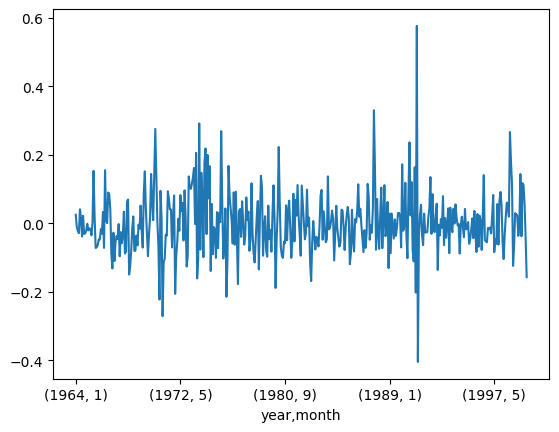

In [164]:
vals = xs['resid'].loc[(1964, 1):]
vals.plot()

In [165]:
# Now we move on to our illiquidity sorted portfolios. For now lets just do the portfolio sorted by illiquidity value rather than it and the variance and cap sorted portfolios

In [166]:
# Again, copy our new dataframe to maintain its integrity
df_AMEX_NYSE_non_market = df_AMEX_NYSE

In [167]:
# We are only working with data from 1963 now so we drop any data from 1962
df_AMEX_NYSE_non_market = df_AMEX_NYSE_non_market.drop(1962, level=1)

In [168]:
# We remove any stock with beginning of the year price outside the range of (5, 1000)
rows_to_delete_on_price = []

df_AMEX_NYSE_grouped = df_AMEX_NYSE_non_market.groupby(['PERMNO', 'year'])
for (name, year), group in df_AMEX_NYSE_grouped:
    row_one = group.iloc[0]
    if (5 <= row_one['PRC'] <= 1000) == False:
        rows_to_delete_on_price.append((name, year))

# We drop them from our main dataframe. This will help us form the new portfolios shortly
index_names = df_AMEX_NYSE_non_market.index.names[:2]
df_AMEX_NYSE_non_market = df_AMEX_NYSE_non_market.reset_index().set_index(index_names)
df_AMEX_NYSE_non_market = df_AMEX_NYSE_non_market.drop(index=rows_to_delete_on_price)

In [169]:
# We return the market caps as we will need them shortly for portfolio sorting. This time the caps are based on yearly caps
AMEX_NYSE_yearly_caps = []
new_index = []

df_AMEX_NYSE_grouped = df_AMEX_NYSE_non_market.groupby(['PERMNO', 'year'])
for (name, year), group in df_AMEX_NYSE_grouped:
    row_one = group.iloc[0]
    new_index.append((name, year))
    AMEX_NYSE_yearly_caps.append(row_one)

df_AMEX_NYSE_non_market_yearly_caps = pd.DataFrame(AMEX_NYSE_yearly_caps, index=new_index, columns=df_AMEX_NYSE_non_market.columns)

In [170]:
# Now we have a dataframe with just the first data of each month for each year for each stock
df_AMEX_NYSE_non_market_yearly_caps.index = pd.MultiIndex.from_tuples(df_AMEX_NYSE_non_market_yearly_caps.index, names=['PERMNO', 'year'])

In [171]:
# Get the number of valid observation days in each month
df_valid_obs_days = df_AMEX_NYSE_non_market.groupby(level=['PERMNO', 'year'])['date'].count()
df_valid_obs_days.to_frame()

# Now find annual illiquidity of all stocks
# Begin by finding daily illquidity of all stocks

# Create a column of ratio of return to dollar volume. On the days where volume is zero, do we still include that day as a valid observation day? 
# We cant divide by zero so we have to set that value to 0 in the sum rather than +/- inf
df_AMEX_NYSE_non_market['ILLIQUIDITY'] = np.abs(df_AMEX_NYSE_non_market['RET']) / df_AMEX_NYSE_non_market['DOLLAR VOL']
df_AMEX_NYSE_non_market['ILLIQUIDITY'] = df_AMEX_NYSE_non_market['ILLIQUIDITY'].fillna(0)
df_AMEX_NYSE_non_market['ILLIQUIDITY'] = df_AMEX_NYSE_non_market['ILLIQUIDITY'].replace([np.inf, -np.inf], 0)

# Create a series with just the illiquidity sum for each valid year
df_illiquidity_sum = df_AMEX_NYSE_non_market.groupby(['PERMNO', 'year'])['ILLIQUIDITY'].sum()
df_illiquidity_var = df_AMEX_NYSE_non_market.groupby(['PERMNO', 'year'])['ILLIQUIDITY'].var()
df_illiquidity_sum.to_frame()
df_illiquidity_var = df_illiquidity_var.to_frame()

In [172]:
# We can now compute illiquidity values for each stock for each year
df_illiquidity_non_market = df_illiquidity_sum.div(df_valid_obs_days, level=0)

df_illiquidity_non_market = df_illiquidity_non_market.to_frame()
df_illiquidity_non_market = df_illiquidity_non_market.rename(columns={0: 'ILLIQUIDITY'})

# Each year's liquidity value is actually the previous full year's, as we are sorting based on year t - 1, so we shift the dataframe
df_illiquidity_non_market = df_illiquidity_non_market.shift()
df_illiquidity_non_market_var = df_illiquidity_var.shift()

In [173]:
# The paper only uses stocks for which they have at least 100 days in the last year of valid values
rows_to_delete_too_few_obs = []

for (name, year) in df_valid_obs_days.index:
    current_row_num = df_valid_obs_days.index.get_loc((name, year))
    if (current_row_num == 0):
        rows_to_delete_too_few_obs.append((name, year))
    else:
        row_num_minus_one = current_row_num - 1
        row_num_minus_one_name = df_valid_obs_days.index[row_num_minus_one][0]
        row_num_minus_one_days = df_valid_obs_days.iloc[row_num_minus_one]

        if (name == row_num_minus_one_name):
            if (row_num_minus_one_days < 100):
                rows_to_delete_too_few_obs.append((name, year))
        else:
            rows_to_delete_too_few_obs.append((name, year))

# We drop them from our main dataframe as well. This will help us form the market portfolio shortly
df_illiquidity_non_market = df_illiquidity_non_market.drop(index=rows_to_delete_too_few_obs)
df_illiquidity_non_market_var = df_illiquidity_non_market_var.drop(index=rows_to_delete_too_few_obs)

In [219]:
df_illiquidity_non_market #this is yearly illiquidity, we also need monthly now

ILLIQUIDITY
PERMNO year             
10006  1964     0.093710
       1965     0.065199
       1966     0.042041
       1967     0.060421
       1968     0.055124
...                  ...
93201  1990     0.037290
93236  1991     0.226386
       1992     0.115062
       1993     0.649002
       1994     0.678272

[77420 rows x 1 columns]

In [174]:
# Group the dataframe by years
df_illiquidity_non_market_year_group = df_illiquidity_non_market.groupby('year')
df_illiquidity_non_market_var_year_group = df_illiquidity_non_market_var.groupby('year')
df_AMEX_NYSE_non_market_yearly_caps_group = df_AMEX_NYSE_non_market_yearly_caps.groupby('year')

In [175]:
# Now we sort into the correct portfolios
# create an empty list to store the split dataframes
df_non_market_increasing_yearly_illiquidity_portfolios = []

# loop over each group
for name, group in df_illiquidity_non_market_year_group:
    # sort the group
    sorted_group = group.sort_values('ILLIQUIDITY')
    # divide the sorted group into 25 equal parts
    split_group = np.array_split(sorted_group, 25)
    # append the split group to the list of split dataframes
    df_non_market_increasing_yearly_illiquidity_portfolios += split_group

In [188]:
# We need to find the return of the portfolio for each month t. We assume equal weights for now but can amend later if need be.
# First step is to gather the data into year, month combinations
# We also return the market caps as we will need them shortly for illiquidity calcs
AMEX_NYSE_monthly_prices = []
AMEX_NYSE_monthly_caps = []
new_index = []

df_AMEX_NYSE_non_market = df_AMEX_NYSE_non_market.reset_index().set_index(['PERMNO', 'year', 'month'])
df_AMEX_NYSE_grouped = df_AMEX_NYSE_non_market.groupby(['PERMNO', 'year', 'month'])
for (name, year, month), group in df_AMEX_NYSE_grouped:
    row_one = group.iloc[0]
    row_last = group.iloc[len(group) - 1]
    new_index.append((name, year, month))
    AMEX_NYSE_monthly_prices.append(row_one)
    AMEX_NYSE_monthly_caps.append(row_last)

df_AMEX_NYSE_non_market_monthly_prices = pd.DataFrame(AMEX_NYSE_monthly_prices, index=new_index, columns=df_AMEX_NYSE_non_market.columns)
df_AMEX_NYSE_non_market_monthly_caps = pd.DataFrame(AMEX_NYSE_monthly_caps, index=new_index, columns=df_AMEX_NYSE_non_market.columns)

In [189]:
# Now we have a dataframe with just the first data of each month for each year for each stock
df_AMEX_NYSE_non_market_monthly_prices.index = pd.MultiIndex.from_tuples(df_AMEX_NYSE_non_market_monthly_prices.index, names=['PERMNO', 'year', 'month'])

# Now we have a dataframe with just the last data of each month for each year for each stock
df_AMEX_NYSE_non_market_monthly_caps.index = pd.MultiIndex.from_tuples(df_AMEX_NYSE_non_market_monthly_caps.index, names=['PERMNO', 'year', 'month'])

# Get each stock's monthly return
df_AMEX_NYSE_non_market_monthly_prices['MONTHLY RETURNS'] = df_AMEX_NYSE_non_market_monthly_prices.groupby(['PERMNO'])['PRC'].pct_change()

In [ ]:
# We now have to repeat this proceedure for the adjusted illiquidity values c. To do this we bring over the functions used in the other ipynb. Note: the calculation for adjusted illiquidity takes a very long time

# Now we get monthly market cap ratios as defined in the paper
df_AMEX_NYSE_non_market_monthly_portfolio_caps = df_AMEX_NYSE_non_market_monthly_caps.groupby(['year', 'month'])

monthly_portfolio_caps = []
new_index = []

for (year, month), group in df_AMEX_NYSE_non_market_monthly_portfolio_caps:
    new_index.append((year, month))
    col = group['MKT CAP']
    L = len(col)
    cap = col.values/L
    cap = np.nansum(cap)
    monthly_portfolio_caps.append(cap)

df_AMEX_NYSE_non_market_monthly_portfolio_caps = pd.DataFrame(monthly_portfolio_caps, index=new_index, columns=['CAP'])

In [ ]:
# Now we have the market portfolio monthly caps by equal weight
df_AMEX_NYSE_non_market_monthly_portfolio_caps.index = pd.MultiIndex.from_tuples(df_AMEX_NYSE_non_market_monthly_portfolio_caps.index, names=['year', 'month'])

In [ ]:
# We now need the cap ratios to the cap of July 1962
#base = df_AMEX_NYSE_monthly_portfolio_caps.loc[('1962', '07'), 'CAP']
base = 0.19308631191927988
df_AMEX_NYSE_non_market_monthly_portfolio_caps['RATIO'] = df_AMEX_NYSE_non_market_monthly_portfolio_caps['CAP'] / base

In [ ]:
# Now find market portfolio illiquidity
# Begin by finding daily illquidity of all stocks

# Get the number of valid observation days in each month. Have to do this again as a number of stocks were dropped when we last used this method
df_valid_obs_days = df_AMEX_NYSE_non_market.groupby(level=['PERMNO', 'year', 'month'])['date'].count()
df_valid_obs_days.to_frame()

# Create a series with just the illiquidity sum for each valid month
df_illiquidity_sum = df_AMEX_NYSE_non_market.groupby(['PERMNO', 'year', 'month'])['ILLIQUIDITY'].sum()
df_illiquidity_sum.to_frame()

In [ ]:
# We can now compute illiquidity values for each stock for each month of each year
df_non_market_illiquidity = df_illiquidity_sum.div(df_valid_obs_days, level=0)

df_non_market_illiquidity = df_non_market_illiquidity.to_frame()
df_non_market_illiquidity = df_non_market_illiquidity.rename(columns={0: 'ILLIQUIDITY'})

In [ ]:
'''# Now we can find the illiquidity adjustments c as described in the paper
# To do so we first combine our illiquidity and cap dataframe so that each stock for each month of each year is multiplied by the correct ratio from the cap dataframe

df_non_market_illiquidity['ADJUSTED ILLIQUIDITY'] = np.zeros(len(df_non_market_illiquidity))

for index in df_non_market_illiquidity.index:
    pos = index[1:3]

    if (pos == (1962, 7)):
        df_non_market_illiquidity.loc[index, 'ADJUSTED ILLIQUIDITY'] = df_non_market_illiquidity.loc[index, 'ILLIQUIDITY']
    else:
        i = df_AMEX_NYSE_non_market_monthly_portfolio_caps.index.get_loc(pos)
        ratio = df_AMEX_NYSE_non_market_monthly_portfolio_caps.iloc[i - 1, 1]
        df_non_market_illiquidity.loc[index, 'ADJUSTED ILLIQUIDITY'] = df_non_market_illiquidity.loc[index, 'ILLIQUIDITY'] * ratio

# Now we can compute c
df_non_market_illiquidity['c'] = np.minimum(0.25 + 0.3 * df_non_market_illiquidity['ADJUSTED ILLIQUIDITY'], 30.)'''


In [240]:
'''# Save the file
df_non_market_illiquidity.to_csv('Data/AMEX_NYSE_daily_illiquidity_non_market.csv')

'''# Takes a long time so just read in instead
df_non_market_illiquidity = pd.read_csv('Data/AMEX_NYSE_daily_illiquidity_non_market.csv', index_col=['PERMNO', 'year', 'month'])

In [270]:
df_AMEX_NYSE_non_market_monthly_portfolio_caps['ADJUSTED RATIO'] = (30. - 0.25) / (0.3 * df_AMEX_NYSE_non_market_monthly_portfolio_caps['RATIO'].shift(1))

In [273]:
# We need to compute the returns and illiquidity c values for each portfolio 
# Start with the increasing illiquidity portfolio
# The structure is dictionary with key = year and value = dictionary. This second dictionary has key = the portfolio number and value = dataframe of monthly returns
df_non_market_increasing_yearly_illiquidity_portfolios_returns = {}
i = 0

for portfolio in df_non_market_increasing_yearly_illiquidity_portfolios:
    # For each portfolio get its position in the order and year
    portfolio_number = i % 25
    portfolio_year = portfolio.index[0][1]
    
    # If this is the first portfolio make a dictionary to save the portfolio numbers and their dataframes
    if i == 0:
        dictionary_for_portfolio_year = {}
    
    # Get monthly returns and add to dictionary 
    portfolio_stocks = list(portfolio.index.get_level_values(level=0))
    portfolio_monthly_returns = df_AMEX_NYSE_non_market_monthly_prices.xs(portfolio_year, level=1)
    portfolio_monthly_returns = portfolio_monthly_returns.loc[portfolio_stocks]
    
    # Groupby month and calculate monthly returns for each stock in portfolio before summing and averaging
    portfolio_monthly_returns = portfolio_monthly_returns.groupby(['month'])
    new_index = []
    rets = []

    for (month), group in portfolio_monthly_returns:
        new_index.append(int(month))
        col = group['MONTHLY RETURNS']
        L = len(col)
        ret = col.values/L
        ret = np.nansum(ret, axis=0)
        rets.append(ret)
    
    # Do the same for mkt caps
    portfolio_monthly_caps = df_AMEX_NYSE_non_market_monthly_caps.xs(portfolio_year, level=1)
    portfolio_monthly_caps = portfolio_monthly_caps.loc[portfolio_stocks]
    
    # Groupby month and calculate monthly returns for each stock in portfolio before summing and averaging
    portfolio_monthly_caps = portfolio_monthly_caps.groupby(['month'])
    #new_index = []
    caps = []

    for (month), group in portfolio_monthly_caps:
        #new_index.append(int(month))
        col = group['MKT CAP']
        L = len(col)
        cap = col.values/L
        cap = np.nansum(cap, axis=0)
        caps.append(cap)

    # Get monthly c and add to dictionary 
    portfolio_monthly_c = df_non_market_illiquidity.xs(portfolio_year, level=1)
    portfolio_monthly_c = portfolio_monthly_c.loc[portfolio_stocks]
    
    # Groupby month and calculate monthly c for each stock in portfolio before summing and averaging
    portfolio_monthly_c = portfolio_monthly_c.groupby(['month'])
    #new_index = []
    cs = []

    for (month), group in portfolio_monthly_c:
        #new_index.append(int(month))
        col = group['c']
        L = len(col)
        c = col.values/L
        c = np.nansum(c, axis=0)
        cs.append(c)
    
    #new_index = []
    bars = []
    for (month), group in portfolio_monthly_c:
        #new_index.append(int(month))
        adjusted_ratio = df_AMEX_NYSE_non_market_monthly_portfolio_caps.loc[(year, month), 'ADJUSTED RATIO']
        col = group['ILLIQUIDITY']
        L = len(col)
        adjusted_ratio_arr = np.ones(L) * adjusted_ratio

        # Compare the arrays to find the minimum of the adjusted ratio and the illiquidity
        unnormalized_illiquidities = np.minimum(col.values, adjusted_ratio_arr)
        bar = col.values/L
        bar = np.nansum(bar, axis=0)
        bars.append(bar)

    # We now need the cap ratios to the cap of July 1962
    #base = df_AMEX_NYSE_monthly_portfolio_caps.loc[('1962', '07'), 'CAP']
    base = 0.19308631191927988
    
    # Make a dataframe of monthly returns and add to dictionary with key of the portfolio number
    df_portfolio_for_current_year = pd.DataFrame(rets, index=new_index, columns=['RET'])
    df_portfolio_for_current_year['CAP'] = caps
    df_portfolio_for_current_year['RATIO'] = df_portfolio_for_current_year['CAP'] / base
    df_portfolio_for_current_year['c'] = cs
    df_portfolio_for_current_year['ILLIQ_bar'] = bars
    dictionary_for_portfolio_year[portfolio_number] = df_portfolio_for_current_year

    if portfolio_number == 24 and i != 0:
        # If we have reached 25 portfolios then we are in a new year again so we add the dictionary of the portfolio number : dataframe of monthly returns to the overall dictionary
        # We then start again with a new year
        df_non_market_increasing_yearly_illiquidity_portfolios_returns[int(portfolio_year)] = dictionary_for_portfolio_year
        dictionary_for_portfolio_year = {}

    i += 1


In [279]:
df_non_market_increasing_yearly_illiquidity_portfolios_returns[1964][0]

,RET,CAP,RATIO,c,ILLIQ_bar
1,0.016104,3.172536,16.430662,0.254995,0.013318
2,-0.013964,3.216404,16.657859,0.255084,0.013237
3,0.012111,3.258614,16.876465,0.255031,0.012941
4,-0.001761,3.288644,17.031991,0.257233,0.018327
5,0.007045,3.333760,17.265649,0.256673,0.016843
6,-0.005039,3.380452,17.507468,0.257555,0.018927
7,0.008302,3.427170,17.749421,0.257718,0.019120
8,0.000975,3.363402,17.419165,0.259738,0.023761
9,-0.004772,3.460288,17.920941,0.256885,0.017069
10,0.026766,3.480551,18.025884,0.258468,0.020503


In [280]:
df_all_portfolios = pd.DataFrame.from_dict(df_non_market_increasing_yearly_illiquidity_portfolios_returns)

In [284]:
df_all_portfolios

,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,RET CAP RATIO c I...,RET CAP RATIO c I...,RET CAP RATIO c I...,RET CAP RATIO c I...,RET CAP RATIO c I...,RET CAP RATIO c I...,RET CAP RATIO c I...,RET CAP RATIO c I...,RET CAP RATIO c I...,RET CAP RATIO c I...,...,RET CAP RATIO c ...,RET CAP RATIO c ...,RET CAP RATIO c ...,RET CAP RATIO c ...,RET CAP RATIO c ...,RET CAP RATIO c ...,RET CAP RATIO c ...,RET CAP RATIO c ...,RET CAP RATIO c ...,RET CAP RATIO c ...
1,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,...,RET CAP RATIO c I...,RET CAP RATIO c I...,RET CAP RATIO c I...,RET CAP RATIO c I...,RET CAP RATIO c I...,RET CAP RATIO c I...,RET CAP RATIO c I...,RET CAP RATIO c ...,RET CAP RATIO c ...,RET CAP RATIO c ...
2,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,...,RET CAP RATIO c I...,RET CAP RATIO c I...,RET CAP RATIO c I...,RET CAP RATIO c I...,RET CAP RATIO c I...,RET CAP RATIO c I...,RET CAP RATIO c I...,RET CAP RATIO c I...,RET CAP RATIO c I...,RET CAP RATIO c I...
3,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,...,RET CAP RATIO c I...,RET CAP RATIO c I...,RET CAP RATIO c I...,RET CAP RATIO c I...,RET CAP RATIO c I...,RET CAP RATIO c I...,RET CAP RATIO c I...,RET CAP RATIO c I...,RET CAP RATIO c I...,RET CAP RATIO c I...
4,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,...,RET CAP RATIO c IL...,RET CAP RATIO c I...,RET CAP RATIO c I...,RET CAP RATIO c I...,RET CAP RATIO c I...,RET CAP RATIO c I...,RET CAP RATIO c I...,RET CAP RATIO c I...,RET CAP RATIO c I...,RET CAP RATIO c I...
5,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c I...,RET CAP RATIO c I...,RET CAP RATIO c I...
6,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...
7,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...
8,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,RET CAP RATIO c IL...,

In [304]:
# Create a new DataFrame to store the extracted values
new_df = pd.DataFrame()

# Loop over the columns of the original DataFrame
row_one = df_all_portfolios.iloc[0]
row_one = row_one.to_frame()
for idx in row_one.index:
    # Extract the values from the column
    data = row_one.loc[idx]
    print(data.values)
    # Set the column name as the index of the extracted values
    data.index = pd.MultiIndex.from_product([[col], data.index])
    # Add the extracted values to the new DataFrame
    new_df = pd.concat([new_df, data.values], axis=0)


[         RET       CAP      RATIO         c  ILLIQ_bar
 1   0.016104  3.172536  16.430662  0.254995   0.013318
 2  -0.013964  3.216404  16.657859  0.255084   0.013237
 3   0.012111  3.258614  16.876465  0.255031   0.012941
 4  -0.001761  3.288644  17.031991  0.257233   0.018327
 5   0.007045  3.333760  17.265649  0.256673   0.016843
 6  -0.005039  3.380452  17.507468  0.257555   0.018927
 7   0.008302  3.427170  17.749421  0.257718   0.019120
 8   0.000975  3.363402  17.419165  0.259738   0.023761
 9  -0.004772  3.460288  17.920941  0.256885   0.017069
 10  0.026766  3.480551  18.025884  0.258468   0.020503
 11  0.002502  3.419535  17.709875  0.257801   0.018729
 12 -0.025929  3.484294  18.045268  0.261694   0.028333]


TypeError: cannot concatenate object of type '<class 'numpy.ndarray'>'; only Series and DataFrame objs are valid

In [301]:
new_df

,0
"(0, 0)",RET CAP RATIO c I...
"(0, 0)",RET CAP RATIO c I...
"(0, 0)",RET CAP RATIO c I...
"(0, 0)",RET CAP RATIO c I...
"(0, 0)",RET CAP RATIO c I...
"(0, 0)",RET CAP RATIO c I...
"(0, 0)",RET CAP RATIO c I...
"(0, 0)",RET CAP RATIO c I...
"(0, 0)",RET CAP RATIO c I...
"(0, 0)",RET CAP RATIO c I...


In [258]:
'''# We need to compute the returns and illiquidity c values for each portfolio 
# Start with the increasing illiquidity portfolio
# The structure is dictionary with key = year and value = dictionary. This second dictionary has key = the portfolio number and value = dataframe of monthly c
df_non_market_increasing_yearly_illiquidity_portfolios_c = {}
i = 0

for portfolio in df_non_market_increasing_yearly_illiquidity_portfolios:
    # For each portfolio get its position in the order and year
    portfolio_number = i % 25
    portfolio_year = portfolio.index[0][1]
    
    # If this is the first portfolio make a dictionary to save the portfolio numbers and their dataframes
    if i == 0:
        dictionary_for_portfolio_year = {}

    # Get monthly c and add to dictionary 
    portfolio_stocks = list(portfolio.index.get_level_values(level=0))
    portfolio_monthly_c = df_non_market_illiquidity.xs(portfolio_year, level=1)
    portfolio_monthly_c = portfolio_monthly_c.loc[portfolio_stocks]
    
    # Groupby month and calculate monthly c for each stock in portfolio before summing and averaging
    portfolio_monthly_c = portfolio_monthly_c.groupby(['month'])
    new_index = []
    cs = []

    for (month), group in portfolio_monthly_c:
        new_index.append(int(month))
        col = group['c']
        L = len(col)
        c = col.values/L
        c = np.nansum(c, axis=0)
        cs.append(c)
    
    # Make a dataframe of monthly c and add to dictionary with key of the portfolio number
    df_portfolio_for_current_year = pd.DataFrame(cs, index=new_index, columns=['c'])
    dictionary_for_portfolio_year[portfolio_number] = df_portfolio_for_current_year

    if portfolio_number == 24 and i != 0:
        # If we have reached 25 portfolios then we are in a new year again so we add the dictionary of the portfolio number : dataframe of monthly c to the overall dictionary
        # We then start again with a new year
        df_non_market_increasing_yearly_illiquidity_portfolios_c[int(portfolio_year)] = dictionary_for_portfolio_year
        dictionary_for_portfolio_year = {}

    i += 1'''


In [275]:
# We need the average illiquidity for each portfoilio in each year. Then we will use these averages per year to calculate an average for the entire period of 1964-1999 for each portfolio
df_non_market_for_portfolio_average_c = pd.DataFrame()
portfolio_numbers = list(range(0, 25))

for year in df_non_market_increasing_yearly_illiquidity_portfolios_returns:
    current_year_dictionary = df_non_market_increasing_yearly_illiquidity_portfolios_returns[year]
    current_year_array = np.ones(25)*year
    current_year_values = []

    for num in current_year_dictionary:
        current_year_num_portfolio = current_year_dictionary[num]
        average = current_year_num_portfolio['c'].mean()
        current_year_values.append(average)

    df_for_current_year_portfolio_average_c = pd.DataFrame(current_year_values, columns=['average c'])
    df_for_current_year_portfolio_average_c['year'] = current_year_array
    df_for_current_year_portfolio_average_c['number'] = portfolio_numbers
    df_for_current_year_portfolio_average_c = df_for_current_year_portfolio_average_c.set_index(['year', 'number'])

    df_non_market_for_portfolio_average_c = pd.concat([df_non_market_for_portfolio_average_c, df_for_current_year_portfolio_average_c], axis=0, join='outer')

        

In [276]:
df_non_market_for_portfolio_average_c

average c
year   number           
1964.0 0        0.257406
       1        0.262858
       2        0.268393
       3        0.277740
       4        0.289413
...                  ...
1999.0 20       1.867269
       21       2.544713
       22       3.274392
       23       4.951457
       24      10.584242

[900 rows x 1 columns]

In [277]:
df_non_market_for_portfolio_average_c_grouped = df_non_market_for_portfolio_average_c.groupby(['number'])
overall_portfolio_average_c_values = []

for number, group in df_non_market_for_portfolio_average_c_grouped:
    col = group['average c']
    average = col.mean()
    overall_portfolio_average_c_values.append(average)

df_non_market_overall_portfolio_average_c = pd.DataFrame(overall_portfolio_average_c_values, index=list(range(0, 25)), columns=['average c'])

In [278]:
df_non_market_overall_portfolio_average_c

,average c
0,0.253269
1,0.257273
2,0.261621
3,0.267329
4,0.275382
5,0.286459
6,0.299684
7,0.316900
8,0.331939
9,0.355790


In [214]:
#Now perform regression

#temp name for easy of reading
x=df_AMEX_NYSE_non_market_monthly_portfolio_caps

y=0.25+0.3*x['ILLIQ_bar']*x['RATIO'].shift(1)
x1=0.25+0.3*x['ILLIQ_bar'].shift(1)*x['RATIO'].shift(1)
x2=0.25+0.3*x['ILLIQ_bar'].shift(2)*x['RATIO'].shift(1)

y=y[2:] #remove observation with NA's in X

#now do regression
#(XTX)^-1(xTY)
x0=np.ones(x1.shape)
xs=pd.DataFrame(x0,columns=['x0'],index=x1.index)
xs['x1']=x1
xs['x2']=x2

xs=xs.dropna()

coefs=np.linalg.inv(xs.T@xs).dot(np.dot(xs.T,y)).T

In [215]:
#Now estimate residuals

xs['y_hat']=(xs*coefs).sum(axis=1)
xs['resid']=y-xs['y_hat']

<AxesSubplot:xlabel='year,month'>

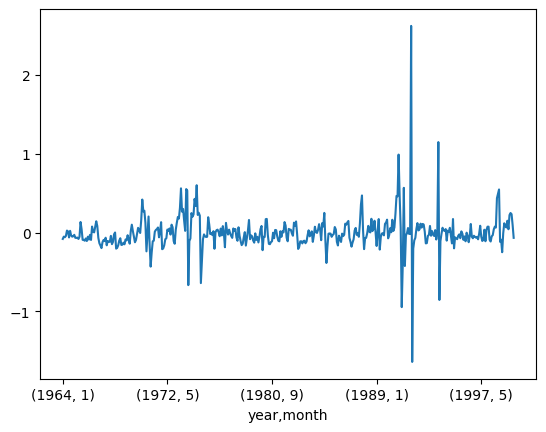

In [216]:
vals = xs['resid'].loc[(1964, 1):]
vals.plot()